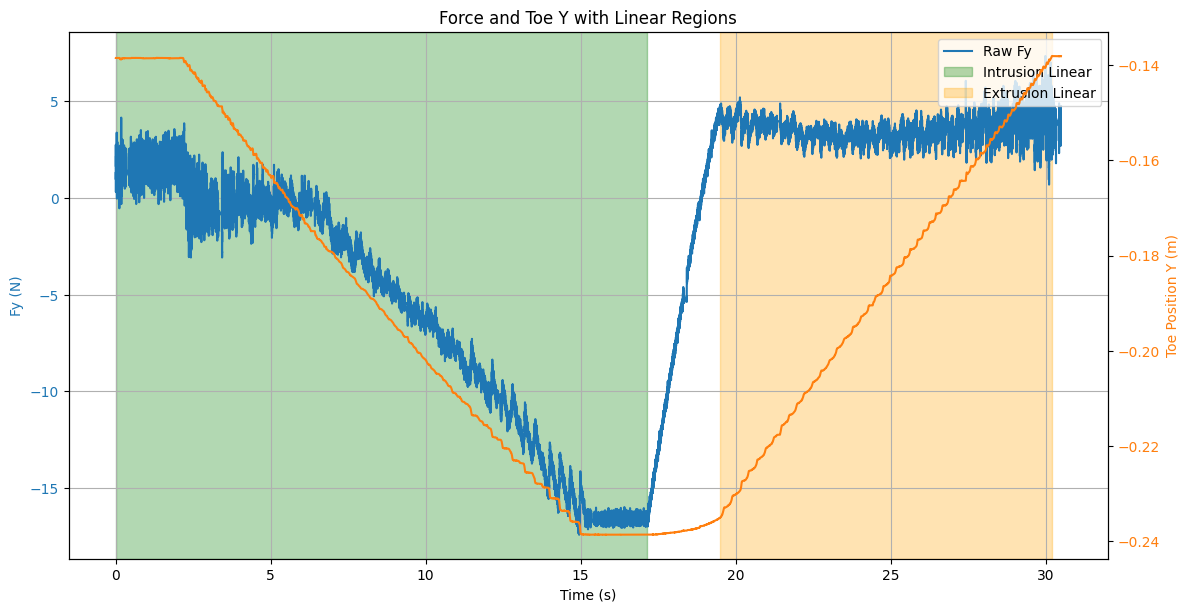

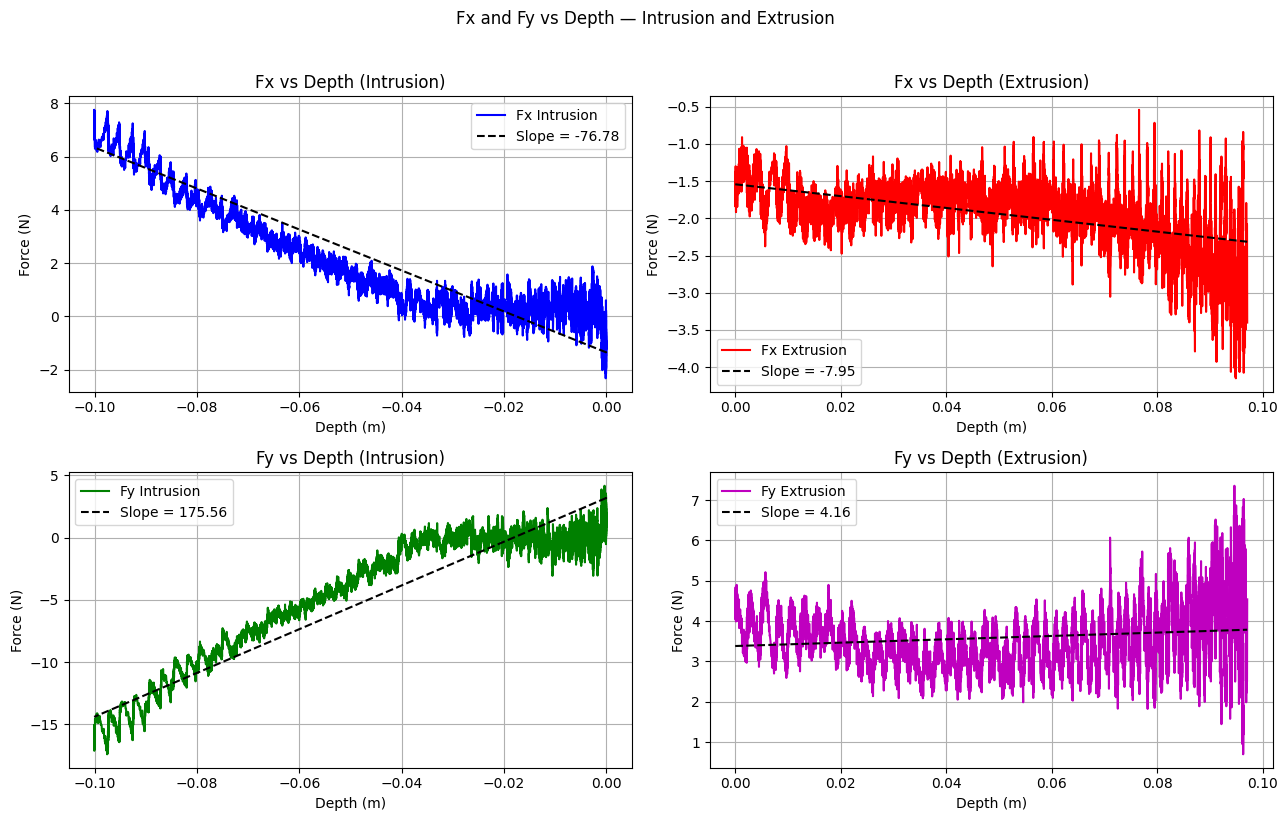

Intrusion Fx slope: -76.7836
Intrusion Fy slope: 175.5581
Extrusion Fx slope: -7.9464
Extrusion Fy slope: 4.1604


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
from scipy.stats import linregress

file_path = r"C:\Users\Tarunika P\Desktop\Summer '25 Intern\USC\LASSIE\LASSIE_DataForHeatMap\LASSIE_DataForHeatMap\plate1ex_angle30\plate1ex_angle30ex_len10_t1_Tue_Jun_17_14_53_33_2025.csv"
df = pd.read_csv(file_path, skiprows=2)

time_col = 'time'
fy_col = 'toeforce_y'
fx_col = 'toeforce_x'
toe_y_col = 'toe_position_y'

def butter_lowpass_filter(data, cutoff, fs, order=3):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, data)

fs = 1 / np.mean(np.diff(df[time_col]))
df['Fy_filtered'] = butter_lowpass_filter(df[fy_col], 3.0, fs)
df['dFy_dt'] = np.gradient(df['Fy_filtered'], df[time_col])

min_idx = df[toe_y_col].idxmin()

for i in range(min_idx - 40, 0, -1):
    seg = df.iloc[i:i + 30]
    if abs(linregress(seg[toe_y_col], seg[fy_col]).rvalue) > 0.98:
        intrusion_start = i
        break
else:
    intrusion_start = 0

df1 = df.iloc[intrusion_start:min_idx + 1].copy()
df1['depth'] = df1[toe_y_col] - df1[toe_y_col].iloc[0]

for i in range(min_idx + 10, len(df) - 5):
    if np.all(np.abs(df['dFy_dt'].iloc[i:i+5]) < 0.2):
        flat_start = i + 5
        break
else:
    flat_start = min_idx + 30

for i in range(flat_start, len(df) - 30):
    seg = df.iloc[i:i+30]
    if abs(linregress(seg[toe_y_col], seg[fy_col]).rvalue) > 0.98:
        extrusion_start = i
        break
else:
    extrusion_start = flat_start

extrusion_end = df[toe_y_col].iloc[extrusion_start:].idxmax()
df2 = df.iloc[extrusion_start:extrusion_end + 1].copy()
df2['depth'] = df2[toe_y_col] - df2[toe_y_col].iloc[0]

fx_slope_1, fx_inter_1, *_ = linregress(df1['depth'], df1[fx_col])
fy_slope_1, fy_inter_1, *_ = linregress(df1['depth'], df1[fy_col])
fx_slope_2, fx_inter_2, *_ = linregress(df2['depth'], df2[fx_col])
fy_slope_2, fy_inter_2, *_ = linregress(df2['depth'], df2[fy_col])

fig, ax1 = plt.subplots(figsize=(12, 6))
ax1.plot(df[time_col], df[fy_col], label='Raw Fy', color='tab:blue')
ax1.axvspan(df[time_col].iloc[intrusion_start], df[time_col].iloc[min_idx], color='green', alpha=0.3, label='Intrusion Linear')
ax1.axvspan(df[time_col].iloc[extrusion_start], df[time_col].iloc[extrusion_end], color='orange', alpha=0.3, label='Extrusion Linear')
ax1.set_xlabel("Time (s)"); ax1.set_ylabel("Fy (N)", color='tab:blue'); ax1.tick_params(axis='y', labelcolor='tab:blue'); ax1.grid(True)

ax2 = ax1.twinx()
ax2.plot(df[time_col], df[toe_y_col], label='Toe Y', color='tab:orange')
ax2.set_ylabel("Toe Position Y (m)", color='tab:orange'); ax2.tick_params(axis='y', labelcolor='tab:orange')

fig.tight_layout(); ax1.legend(loc='upper right')
plt.title("Force and Toe Y with Linear Regions")
plt.show()

fig, axs = plt.subplots(2, 2, figsize=(13, 8))

axs[0, 0].plot(df1['depth'], df1[fx_col], 'b', label='Fx Intrusion')
axs[0, 0].plot(df1['depth'], fx_slope_1 * df1['depth'] + fx_inter_1, 'k--', label=f"Slope = {fx_slope_1:.2f}")
axs[0, 0].set_title("Fx vs Depth (Intrusion)"); axs[0, 0].legend(); axs[0, 0].grid()

axs[1, 0].plot(df1['depth'], df1[fy_col], 'g', label='Fy Intrusion')
axs[1, 0].plot(df1['depth'], fy_slope_1 * df1['depth'] + fy_inter_1, 'k--', label=f"Slope = {fy_slope_1:.2f}")
axs[1, 0].set_title("Fy vs Depth (Intrusion)"); axs[1, 0].legend(); axs[1, 0].grid()

axs[0, 1].plot(df2['depth'], df2[fx_col], 'r', label='Fx Extrusion')
axs[0, 1].plot(df2['depth'], fx_slope_2 * df2['depth'] + fx_inter_2, 'k--', label=f"Slope = {fx_slope_2:.2f}")
axs[0, 1].set_title("Fx vs Depth (Extrusion)"); axs[0, 1].legend(); axs[0, 1].grid()

axs[1, 1].plot(df2['depth'], df2[fy_col], 'm', label='Fy Extrusion')
axs[1, 1].plot(df2['depth'], fy_slope_2 * df2['depth'] + fy_inter_2, 'k--', label=f"Slope = {fy_slope_2:.2f}")
axs[1, 1].set_title("Fy vs Depth (Extrusion)"); axs[1, 1].legend(); axs[1, 1].grid()

for ax in axs.flat:
    ax.set_xlabel("Depth (m)"); ax.set_ylabel("Force (N)")

plt.suptitle("Fx and Fy vs Depth — Intrusion and Extrusion", y=1.02)
plt.tight_layout()
plt.show()

print(f"Intrusion Fx slope: {fx_slope_1:.4f}")
print(f"Intrusion Fy slope: {fy_slope_1:.4f}")
print(f"Extrusion Fx slope: {fx_slope_2:.4f}")
print(f"Extrusion Fy slope: {fy_slope_2:.4f}")


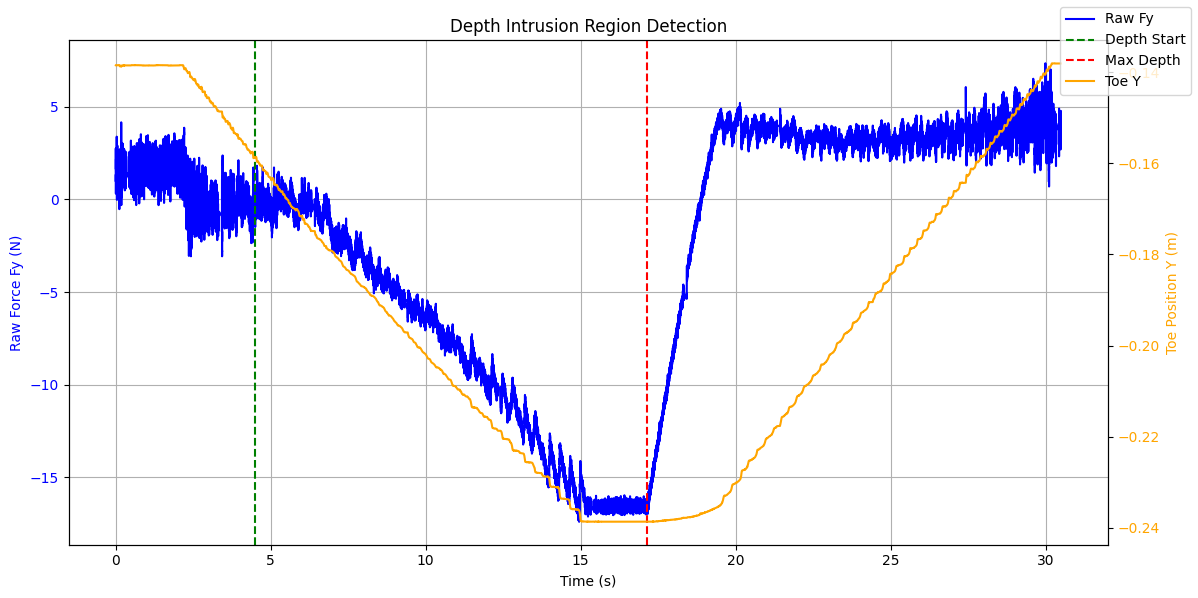

📊 Linear Fit Results (Depth vs Force):
  ➤ Fx Slope: 97.9253 N/m
  ➤ Fy Slope: -231.9187 N/m
  ➤ Depth Start Time: 4.508 s
  ➤ Max Depth Time: 17.128 s


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
from scipy.stats import linregress

def butter_lowpass_filter(data, cutoff, fs, order=3):
    nyq = 0.5 * fs
    norm_cutoff = cutoff / nyq
    b, a = butter(order, norm_cutoff, btype='low', analog=False)
    return filtfilt(b, a, data)

file_path = r"C:\Users\Tarunika P\Desktop\Summer '25 Intern\USC\LASSIE\LASSIE_DataForHeatMap\LASSIE_DataForHeatMap\plate1ex_angle30\plate1ex_angle30ex_len10_t1_Tue_Jun_17_14_53_33_2025.csv"
df = pd.read_csv(file_path, skiprows=2)

time_col = 'time'
toe_y_col = 'toe_position_y'
fx_col = 'toeforce_x'
fy_col = 'toeforce_y'

fs = 1 / np.mean(np.diff(df[time_col]))  # Sampling frequency
df['Fy_filtered'] = butter_lowpass_filter(df[fy_col], cutoff=3.0, fs=fs)
df['dToeY_dt'] = np.gradient(df[toe_y_col], df[time_col])

candidate_range = df[(df[time_col] > 4.5) & (df[time_col] < 6)].index
depth_start_idx = None
for i in candidate_range:
    if df['dToeY_dt'].iloc[i] < -0.001:
        depth_start_idx = i
        break

if depth_start_idx is None:
    raise Exception("Could not detect where depth starts increasing.")

min_depth_idx = df[toe_y_col].idxmin()

df_intrude = df.iloc[depth_start_idx:min_depth_idx + 1].copy()
df_intrude['depth'] = -(df_intrude[toe_y_col] - df_intrude[toe_y_col].iloc[0])  # Depth starts from 0, increases

fx_slope, _, _, _, _ = linregress(df_intrude['depth'], df_intrude[fx_col])
fy_slope, _, _, _, _ = linregress(df_intrude['depth'], df_intrude[fy_col])

fig, ax1 = plt.subplots(figsize=(12, 6))
ax1.plot(df[time_col], df[fy_col], color='blue', label='Raw Fy')
ax1.axvline(df[time_col].iloc[depth_start_idx], color='green', linestyle='--', label='Depth Start')
ax1.axvline(df[time_col].iloc[min_depth_idx], color='red', linestyle='--', label='Max Depth')
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Raw Force Fy (N)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.grid(True)

ax2 = ax1.twinx()
ax2.plot(df[time_col], df[toe_y_col], color='orange', label='Toe Y')
ax2.set_ylabel('Toe Position Y (m)', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

fig.legend(loc='upper right')
plt.title("Depth Intrusion Region Detection")
plt.tight_layout()
plt.show()

print("Linear Fit Results (Depth vs Force):")
print(f" Fx Slope: {fx_slope:.4f} N/m")
print(f" Fy Slope: {fy_slope:.4f} N/m")
print(f" Depth Start Time: {df[time_col].iloc[depth_start_idx]:.3f} s")
print(f" Max Depth Time: {df[time_col].iloc[min_depth_idx]:.3f} s")


Intrusion Fx slope: -11.80, Fy slope: -109.10
Extrusion Fx slope: 6.72, Fy slope: 12.22


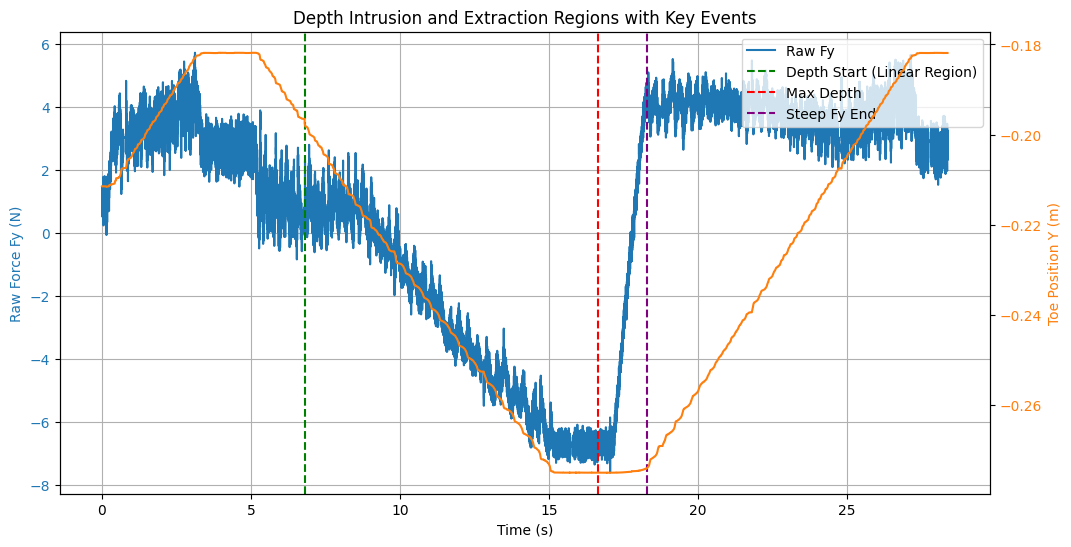

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
from scipy.stats import linregress

%matplotlib inline

def process_file(file_path):
    df = pd.read_csv(file_path, skiprows=2)

    time_col = 'time'
    fx_col = 'toeforce_x'
    fy_col = 'toeforce_y'
    toe_y_col = 'toe_position_y'

    fs = 1 / np.mean(np.diff(df[time_col]))

    def butter_lowpass_filter(data, cutoff, fs, order=3):
        nyq = 0.5 * fs
        norm_cutoff = cutoff / nyq
        b, a = butter(order, norm_cutoff, btype='low', analog=False)
        return filtfilt(b, a, data)

    df['Fy_filtered'] = butter_lowpass_filter(df[fy_col], cutoff=3.0, fs=fs)
    df['dFy_dt'] = np.gradient(df['Fy_filtered'], df[time_col])
    df['dToeY_dt'] = np.gradient(df[toe_y_col], df[time_col])

    min_toe_idx = df[toe_y_col].idxmin()

    # Start of steep rise in Fy
    rise_thresh = 1.0
    window_check = 5
    steep_start_idx = next((i for i in range(min_toe_idx, len(df)-window_check)
                            if np.all(df['dFy_dt'].iloc[i:i+window_check] > rise_thresh)), min_toe_idx)

    flat_thresh = 0.2
    flat_window = 5
    Fy_start = df['Fy_filtered'].iloc[steep_start_idx]
    Fy_max_after = df['Fy_filtered'].iloc[steep_start_idx:].max()
    Fy_rise_thresh = Fy_start + 0.8 * (Fy_max_after - Fy_start)
    steep_end_idx = next((i + flat_window for i in range(steep_start_idx + window_check, len(df) - flat_window)
                          if df['Fy_filtered'].iloc[i] >= Fy_rise_thresh and np.all(np.abs(df['dFy_dt'].iloc[i:i+flat_window]) < flat_thresh)), min_toe_idx)

    # Start of downward movement (depth = 0 point)
    depth_start_idx = next((i for i in range(0, min_toe_idx)
                            if df['dToeY_dt'].iloc[i] < -0.001), 0)

    slope_window = 10
    slopes = [(i, np.polyfit(df[time_col].iloc[i:i+slope_window], df[toe_y_col].iloc[i:i+slope_window], 1)[0])
              for i in range(depth_start_idx, min_toe_idx - slope_window)]
    linear_start_idx, _ = min(slopes, key=lambda x: x[1])

    # 95% of total depth (for intrusion end)
    toe_y_min = df[toe_y_col].iloc[min_toe_idx]
    toe_y_start = df[toe_y_col].iloc[linear_start_idx]
    depth_threshold = toe_y_min + 0.05 * (toe_y_start - toe_y_min)
    depth_95_idx = df[toe_y_col].iloc[linear_start_idx:min_toe_idx][df[toe_y_col].iloc[linear_start_idx:min_toe_idx] < depth_threshold].index[0]

    # Extrusion region: 95% depth to depth zero
    tolerance = 0.001
    post_steep_df = df.iloc[steep_end_idx:]
    depth_diff = (post_steep_df[toe_y_col] - df[toe_y_col].iloc[linear_start_idx]).abs()

    if (depth_diff < tolerance).any():
        zero_depth_idx = depth_diff[depth_diff < tolerance].idxmin()
    else:
        zero_depth_idx = depth_diff.idxmin()

    extrude_95_idx = post_steep_df[post_steep_df[toe_y_col] < depth_threshold].index[0]

    df_intrude = df.loc[linear_start_idx:depth_95_idx].copy()
    df_intrude['depth'] = -(df_intrude[toe_y_col] - df_intrude[toe_y_col].iloc[0])

    df_extrude = df.loc[extrude_95_idx:zero_depth_idx].copy()
    df_extrude['depth'] = -(df_extrude[toe_y_col] - df_extrude[toe_y_col].iloc[-1])

    fx_slope_intrude, fx_intercept_intrude, _, _, _ = linregress(df_intrude['depth'], df_intrude[fx_col])
    fy_slope_intrude, fy_intercept_intrude, _, _, _ = linregress(df_intrude['depth'], df_intrude[fy_col])

    fx_slope_extrude, fx_intercept_extrude, _, _, _ = linregress(df_extrude['depth'], df_extrude[fx_col])
    fy_slope_extrude, fy_intercept_extrude, _, _, _ = linregress(df_extrude['depth'], df_extrude[fy_col])

    print(f"Intrusion Fx slope: {fx_slope_intrude:.2f}, Fy slope: {fy_slope_intrude:.2f}")
    print(f"Extrusion Fx slope: {fx_slope_extrude:.2f}, Fy slope: {fy_slope_extrude:.2f}")

    fig, ax1 = plt.subplots(figsize=(12,6))
    color_fy = 'tab:blue'
    color_toe = 'tab:orange'
    ax1.set_xlabel('Time (s)')
    ax1.set_ylabel('Raw Force Fy (N)', color=color_fy)
    ax1.plot(df[time_col], df[fy_col], color=color_fy, label='Raw Fy')
    ax1.axvline(df[time_col].iloc[linear_start_idx], color='green', linestyle='--', label='Depth Start (Linear Region)')
    ax1.axvline(df[time_col].iloc[min_toe_idx], color='red', linestyle='--', label='Max Depth')
    ax1.axvline(df[time_col].iloc[steep_end_idx], color='purple', linestyle='--', label='Steep Fy End')
    ax1.tick_params(axis='y', labelcolor=color_fy)
    ax1.grid(True)

    ax2 = ax1.twinx()
    ax2.set_ylabel('Toe Position Y (m)', color=color_toe)
    ax2.plot(df[time_col], df[toe_y_col], color=color_toe, label='Toe Y')
    ax2.tick_params(axis='y', labelcolor=color_toe)

    ax1.legend(loc='upper right')
    plt.title("Depth Intrusion and Extraction Regions with Key Events")
    plt.show()

process_file(r"C:\Users\Tarunika P\Desktop\Summer '25 Intern\USC\LASSIE\LASSIE_DataForHeatMap\LASSIE_DataForHeatMap\plate0ex_angle0\plate0ex_angle0ex_len7_t1_Tue_Jun_10_14_37_07_2025.csv")
